# ViT Classification on CIFAR-10

This notebook contains the code to train and evaluate a ViT model on the CIFAR-10 dataset to compare with the Swin Transformer model. All code apart from model definition is exactly the same as the main notebook for training the Swin Transformer model.

**NOTE: We have not implemented the ViT model on our own. We have re-used the tensorflow implementation of the ViT model found at https://github.com/emla2805/vision-transformer**. The ViT model we use has reduced complexity (10M Parameters)

In [21]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import os

#Disable warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

In [23]:
# Load data
batch_size = 64
img_height = 32
img_width = 32

train_ds = tfds.load('cifar10', split='train', shuffle_files=True)
val_ds = tfds.load('cifar10', split='test', shuffle_files=False)

AUTOTUNE = tf.data.AUTOTUNE

# Add data augmentations
trainAug = tf.keras.Sequential([
    tf.keras.layers.Resizing(img_height, img_width),
    tf.keras.layers.Rescaling(scale=1.0 / 255),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
])
# For validation, we just use resize/rescale
valAug = tf.keras.Sequential([
    tf.keras.layers.Resizing(img_height, img_width),
    tf.keras.layers.Rescaling(scale=1.0 / 255)
])

train_ds = train_ds.map(lambda features: (trainAug(features['image']), features['label']), 
                        num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda features: (valAug(features['image']), features['label']), 
                        num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.cache()
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.cache()
val_ds = val_ds.batch(batch_size)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [24]:
images, labels = next(iter(train_ds))
print(images.shape, labels.shape)

(64, 32, 32, 3) (64,)


In [25]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


/usr/local/lib/python3.8/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [26]:
num_batches = train_ds.reduce(0, lambda x,_: x+1).numpy()
print('# of batches in train set: ',num_batches)

# of batches in train set:  782


In [27]:
#Check GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [35]:
input_shape = (img_height, img_width, 3)

learning_rate = 5e-4
num_epochs = 35
weight_decay = 5e-5

total_steps = int(num_epochs * num_batches)

In [36]:
#Define and compile model
from utils.model_vit import VisionTransformer



model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
     VisionTransformer(image_size=32, patch_size=4, num_layers=6,num_classes=1000,mlp_dim=512,num_heads=8,d_model=512),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()
metric1 = tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")
metric2 = tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top3_accuracy")

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay),
    metrics=[metric1, metric2]
)

Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vision_transformer_8 (Visio  (None, 1000)             10303464  
 nTransformer)                                                   
                                                                 
 flatten_3 (Flatten)         (None, 1000)              0         
                                                                 
 dense_462 (Dense)           (None, 10)                10010     
                                                                 
Total params: 10,313,474
Trainable params: 10,313,474
Non-trainable params: 0
_________________________________________________________________


In [37]:
%load_ext tensorboard
import datetime
from utils.callback import OneCycleScheduler

model_name = 'ViT-cifar10'
#Callback for tensorboard logging
log_dir = "runs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'-'+model_name
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
#Callback for saving model checkpoints
checkpoint_filepath = 'model-checkpoints/ViT/'+model_name
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#Define LR Scheduler (OneCycleScheduler)
lr_schedule = OneCycleScheduler(learning_rate, total_steps)

#Train model
history = model.fit(
    train_ds,
    epochs=num_epochs,
    validation_data=val_ds,
    callbacks=[lr_schedule, tensorboard_callback, model_checkpoint_callback]
)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/35
782/782 [==============================] - 138s 164ms/step - loss: 2.3036 - accuracy: 0.1223 - top3_accuracy: 0.3387 - val_loss: 2.3076 - val_accuracy: 0.1398 - val_top3_accuracy: 0.3936
Epoch 2/35
782/782 [==============================] - 126s 161ms/step - loss: 2.1636 - accuracy: 0.1818 - top3_accuracy: 0.4583 - val_loss: 2.2411 - val_accuracy: 0.1487 - val_top3_accuracy: 0.4006
Epoch 3/35
782/782 [==============================] - 126s 161ms/step - loss: 2.1241 - accuracy: 0.1947 - top3_accuracy: 0.4906 - val_loss: 2.1863 - val_accuracy: 0.1734 - val_top3_accuracy: 0.4364
Epoch 4/35
782/782 [==============================] - 126s 161ms/step - loss: 2.1133 - accuracy: 0.2014 - top3_accuracy: 0.5004 - val_loss: 2.1170 - val_accuracy: 0.2045 - val_top3_accuracy: 0.5052
Epoch 5/35
782/782 [==============================] - 126s 161ms/step - loss: 2.0775 - accuracy: 0.2147 - top3_accurac

## Results

We observe that the ViT achieves only ~56% validation accuracy after 35 epochs. We plot accuracy curves and measure the inference time:

In [38]:
# Load Best weights
model.load_weights(checkpoint_filepath)

In [39]:
# Re-evaluate based on loaded weights
metrics = model.evaluate(val_ds, verbose=2)
print("Restored model: (loss, validation accuracy, validation top-3 accuracy)\n ",metrics)

157/157 - 8s - loss: 1.2472 - accuracy: 0.5631 - top3_accuracy: 0.8529 - 8s/epoch - 51ms/step
Restored model: (loss, validation accuracy, validation top-3 accuracy)
  [1.2471970319747925, 0.5630999803543091, 0.8529000282287598]


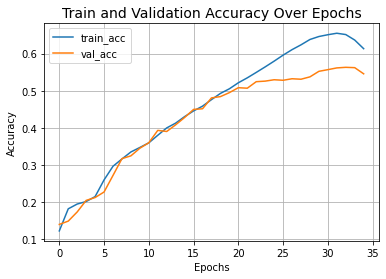

In [40]:
# Plot accuracy curve
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Check inference time
import time

images, labels = next(iter(val_ds))
start_time = time.time() # set the time at which inference started
model.predict(tf.expand_dims(images[0], axis=0))
stop_time = time.time()
duration = stop_time - start_time
hours = duration // 3600
minutes = (duration - (hours * 3600)) // 60
seconds = duration - ((hours * 3600) + (minutes * 60))
msg = f'training elapsed time was {seconds * 1000} ms)'
print (msg, flush=True)